<a href="https://colab.research.google.com/github/brscn2/K-Means-Clustering-w-GUI/blob/main/ch4_under_the_hood_digit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train')]

In [ ]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

<Axes: >

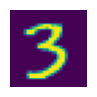

In [ ]:
show_image(three_tensors[1])

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
# length of shape is rank
len(stacked_threes.shape)

3

In [ ]:
# get rank directly
stacked_threes.ndim

3

<Axes: >

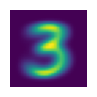

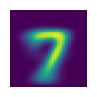

In [ ]:
# find how ideal 3 looks by finding the average for each pixel
mean3 = stacked_threes.mean(0)
show_image(mean3)
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<Axes: >

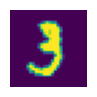

In [ ]:
a_3 = stacked_threes[0]
show_image(a_3)

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1074), tensor(0.1912))

In [ ]:
a_7 = stacked_sevens[0]

dist_7_abs = (a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1095), tensor(0.2196))

In [ ]:
# torch.nn.functional has these as loss functions
import torch.nn.functional as F

F.l1_loss(a_3.float(), mean3), F.mse_loss(a_3, mean3).sqrt()

(tensor(0.1074), tensor(0.1912))

In [ ]:
# creating a tensor
data = [[1,2,3],[4,5,6]]
tns = tensor(data)
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
tns[1]

tensor([4, 5, 6])

In [ ]:
tns[:,1]

tensor([2, 5])

In [ ]:
tns[1,1:3]

tensor([5, 6])

In [ ]:
tns.type()

'torch.LongTensor'

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1074)

In [ ]:
# take advantage of broadcasting instead of loops
mnist_distance(valid_3_tens, mean3)

tensor([0.1399, 0.1200, 0.1174,  ..., 0.1107, 0.1593, 0.1116])

In [ ]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)
def is_7(x): return mnist_distance(x, mean7) < mnist_distance(x, mean3)

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = is_7(valid_7_tens).float().mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [ ]:
# gradient descent
def f(x): return x**2

xt = tensor(3.).requires_grad_()
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
yt.backward() # refers to backpropagation
xt.grad

tensor(6.)

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()

def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

In [ ]:
# The MNIST Loss Function

# -1 => make this axis as big as to fit the data
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

# the labels, 1 for three 7 for zero
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [ ]:
# A dataset in PyTorch is required to return a tuple (x,y) when indexed

dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28, 1))

bias = init_params(1)

In [ ]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
dls = DataLoaders(dl, valid_dl)
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds > 0.5) == yb
  return correct.float().mean()

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.452872,0.442170,0.915604,00:00
1,0.439291,0.422597,0.937193,00:00
2,0.423962,0.403835,0.948479,00:00
3,0.407790,0.386005,0.951914,00:00
4,0.391495,0.369174,0.955348,00:00
5,0.375554,0.353371,0.955839,00:00
6,0.360240,0.338589,0.957802,00:00
7,0.345694,0.324802,0.956330,00:00
8,0.331975,0.311967,0.956820,00:00
9,0.319097,0.300032,0.957802,00:00


In [ ]:
simple_net = nn.Sequential(nn.Linear(28*28, 30),nn.ReLU(), nn.Linear(30,1))

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.290506,0.415686,0.504416,00:00
1,0.138587,0.227566,0.808145,00:00
2,0.077993,0.115333,0.915113,00:00
3,0.052006,0.078173,0.940137,00:00
4,0.039829,0.061064,0.955839,00:00
5,0.033532,0.051386,0.964181,00:01
6,0.029871,0.045259,0.965162,00:00
7,0.027463,0.041074,0.968106,00:00
8,0.025716,0.038031,0.969578,00:00
9,0.024353,0.035713,0.970559,00:00


0.983316957950592

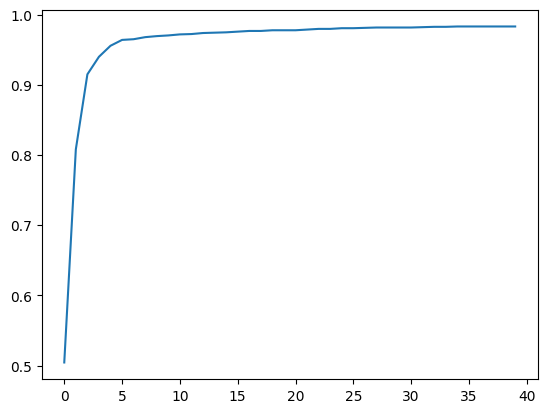

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));
learn.recorder.values[-1][2]